In [ ]:
# !pip3 install torch torchvision
# !pip3 install pillow==4.1.1

In [1]:
import numpy as np

In [2]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

# Neural Style Transfer с двумя картинками

## Input

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

imsize

512

In [40]:
! wget https://listim.com/upload/2019/10/s1200.jpg
! wget https://nyblog.ru/wp-content/uploads/2020/10/pablo-pikasso-kartiny-kubizm-foto-7.jpg
! wget https://pbs.twimg.com/media/EfQTPdYWsAAtsoj.jpg
! wget https://upload.wikimedia.org/wikipedia/commons/f/f4/The_Scream.jpg
! wget https://upload.wikimedia.org/wikipedia/commons/0/0e/Monet%2C_Claude_-_Corner_of_the_Garden_at_Montgeron.jpg

--2021-01-09 13:47:42--  https://upload.wikimedia.org/wikipedia/commons/f/f4/The_Scream.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4219156 (4.0M) [image/jpeg]
Saving to: ‘The_Scream.jpg’

The_Scream.jpg      100%[===================>]   4.02M  --.-KB/s    in 0.1s    

2021-01-09 13:47:43 (29.1 MB/s) - ‘The_Scream.jpg’ saved [4219156/4219156]



In [5]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [41]:
style_img_1 = image_loader("s1200.jpg")
style_img_2 = image_loader("pablo-pikasso-kartiny-kubizm-foto-7.jpg")
style_img_3 = image_loader("The_Scream.jpg")
style_img_4 = image_loader("Monet,_Claude_-_Corner_of_the_Garden_at_Montgeron.jpg")
content_img = image_loader("EfQTPdYWsAAtsoj.jpg")

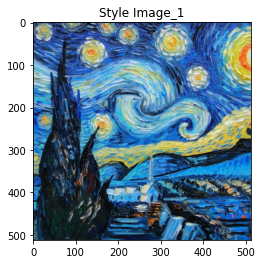

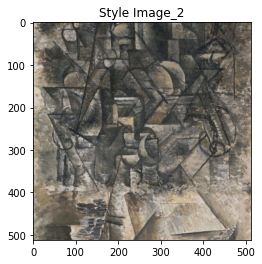

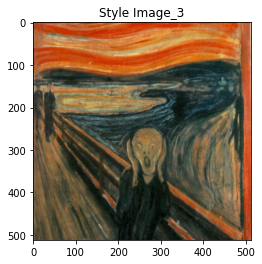

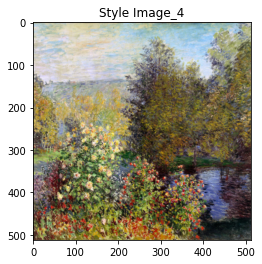

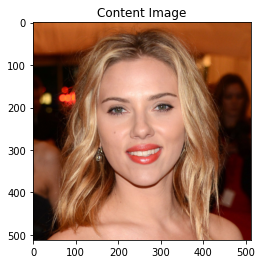

In [42]:
unloader = transforms.ToPILImage() 

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

plt.figure()
imshow(style_img_1, title='Style Image_1')

plt.figure()
imshow(style_img_2, title='Style Image_2')

plt.figure()
imshow(style_img_3, title='Style Image_3')

plt.figure()
imshow(style_img_4, title='Style Image_4')

plt.figure()
imshow(content_img, title='Content Image')

## Loss

In [9]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [10]:
def gram_matrix(input):
        #print('input size in Gramm:', input.size() ) 
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL
        #('Get features with shape: ', features.shape)
        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [11]:
# THIS WORKS
class StyleLoss(nn.Module):
        def __init__(self, target_feature, mode):
            super(StyleLoss, self).__init__()

            # Определяем размер входного изображения и рабочего; а также режим работы
            _size = np.array( target_feature.shape )
            _size = (_size[0], _size[1], _size[2], int( _size[3] / 2 ) )

            self.size = _size
            self.mode = mode

            # Определяем маску
            if mode == 'floor':
              self.mask = torch.cat( (torch.zeros(_size), torch.ones(_size) ), 3 )
            else:              
              self.mask = torch.cat( (torch.ones(_size), torch.zeros(_size) ), 3 )
            #print(target_feature.shape, self.mask.shape, _size)
            self.target = gram_matrix( target_feature ).detach() 

            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            x = input[self.mask > 0].view(self.size)
            G = gram_matrix(x) # ????????????????????
            self.loss = F.mse_loss(G, self.target) 
            return input

## Model

In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [13]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [14]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [15]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [16]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img_1, style_img_2, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses_1 = []
        style_losses_2 = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img_1).detach()
                #print('adding style_layer_1 on layer ', name, ' with shape ', target_feature.shape)
                style_loss = StyleLoss(target_feature, mode = 'сeil') # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                model.add_module("style_loss_1_{}".format(i), style_loss)
                style_losses_1.append(style_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img_2).detach()
                #print('adding style_layer_2 on layer ', name, ' with shape ', target_feature.shape)
                style_loss = StyleLoss(target_feature, mode = 'floor') # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                model.add_module("style_loss_2_{}".format(i), style_loss)
                style_losses_2.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses_1, style_losses_2, content_losses

In [17]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

## Training

In [18]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img_1, style_img_2, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses_1, style_losses_2, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img_1, style_img_2, content_img) # !!!!!!!!!!!!!!!!
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses_1: # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                    style_score += sl.loss
                for sl in style_losses_2:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

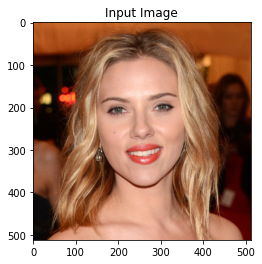

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 3224.431152 Content Loss: 21.147215

run [100]:
Style Loss : 542.931763 Content Loss: 21.649010

run [150]:
Style Loss : 199.488266 Content Loss: 21.951721

run [200]:
Style Loss : 97.256050 Content Loss: 22.072063

run [250]:
Style Loss : 57.887085 Content Loss: 22.034443

run [300]:
Style Loss : 37.096169 Content Loss: 21.826954

run [350]:
Style Loss : 24.441036 Content Loss: 21.528904

run [400]:
Style Loss : 16.432867 Content Loss: 21.184559

run [450]:
Style Loss : 11.482080 Content Loss: 20.762577

run [500]:
Style Loss : 8.503307 Content Loss: 20.325874



In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img_1, style_img_2, input_img, style_weight=1e+7, content_weight=1, num_steps = 500)

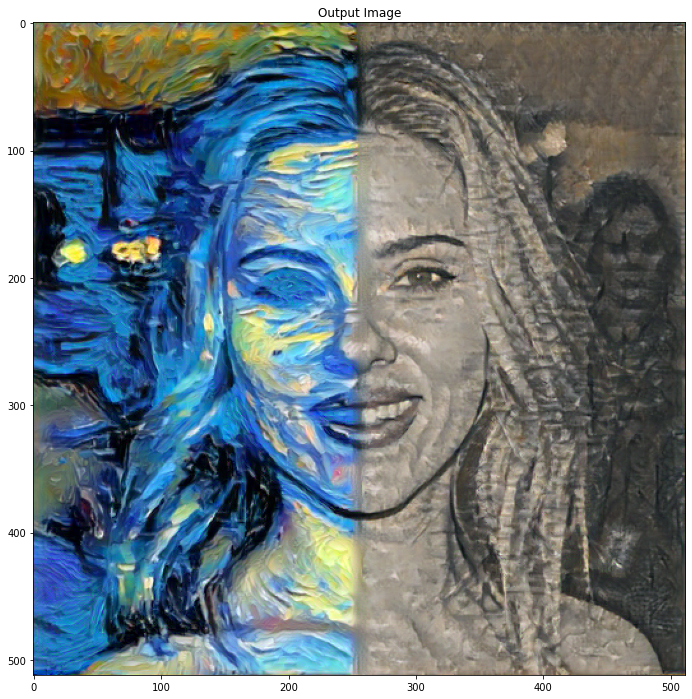

In [ ]:
# style_weight=1e+7, content_weight=1

plt.figure(figsize=(12, 12))
imshow(output, title='Output Image')
plt.ioff()
plt.show()

In [ ]:
x = output.detach().cpu().numpy()
x = np.concatenate( (x[0][0].reshape( (512, 512, 1) ), x[0][1].reshape( (512, 512, 1) ), x[0][2].reshape( (512, 512, 1) )), axis = 2  )

plt.imsave('output.png', x )

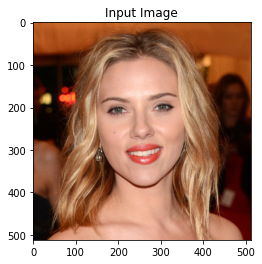

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 877.869995 Content Loss: 14.849193

run [100]:
Style Loss : 264.659424 Content Loss: 16.452291

run [150]:
Style Loss : 135.274673 Content Loss: 16.944466

run [200]:
Style Loss : 86.555740 Content Loss: 17.229370

run [250]:
Style Loss : 57.629822 Content Loss: 17.255259

run [300]:
Style Loss : 37.870422 Content Loss: 17.201752

run [350]:
Style Loss : 24.869886 Content Loss: 17.082563

run [400]:
Style Loss : 15.938019 Content Loss: 16.937033

run [450]:
Style Loss : 10.671238 Content Loss: 16.725296

run [500]:
Style Loss : 7.428123 Content Loss: 16.392231



In [43]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img_3, style_img_4, input_img, style_weight=1e+7, content_weight=1, num_steps = 500)

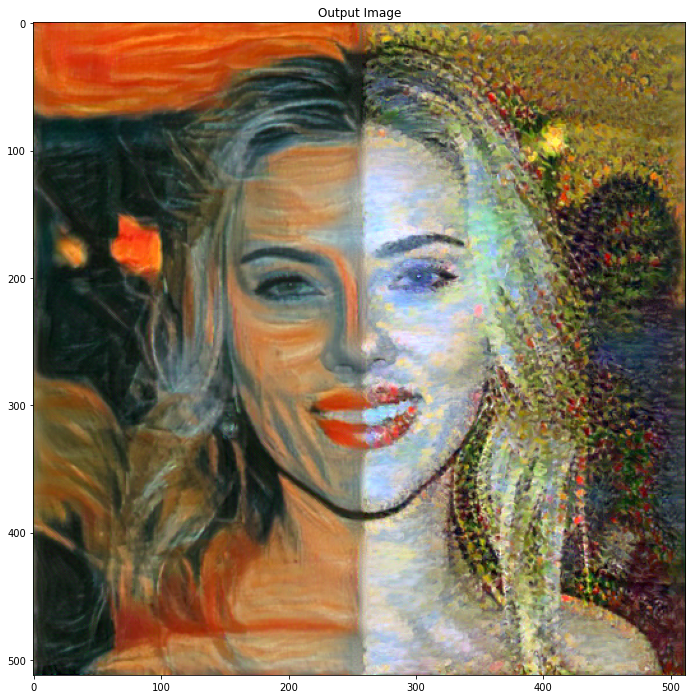

In [44]:
plt.figure(figsize=(12, 12))
imshow(output, title='Output Image')
plt.ioff()
plt.show()

В целом стиль переносится очень хорошо с картин с ярко выраженными мазками. В случае с другими характерными структурами (например, кубизм), влияние стиля тоже видно, но не создает масштабного эффекта, скорее речь идет о локальных деформациях. В других случаях перенос стиля может быть довольно затруднителен